In [1]:

import numpy as np
from numpy.linalg import solve
from scipy.linalg import lu_factor, lu_solve
from typing import Tuple, Dict, Callable, Optional
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import RegularGridInterpolator

def create_interior_matrices(n: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, Dict]:
    """
    Create the reduced interior-only matrices for an (n+1)×(n+1) grid.
    
    Parameters
    ----------
    n : int
        Grid parameter. Grid has indices 1 to n+1, so (n+1)×(n+1) total points.
        Interior points have indices 2 to n, giving (n-1)×(n-1) interior points.
    
    Returns
    -------
    I : ndarray
        Identity matrix, shape ((n-1)², (n-1)²)
    L2 : ndarray
        Laplacian matrix (multiply by 1/h² for actual operator)
    L4 : ndarray
        Biharmonic matrix (multiply by 1/h⁴ for actual operator)
    info : dict
        Dictionary containing grid information and mappings
    
    Example
    -------
    >>> I, L2, L4, info = create_interior_matrices(n=5)
    >>> print(f"Interior points: {info['N_int']}")
    Interior points: 16
    """
    
    # Interior indices (1-based grid notation)
    interior_indices = list(range(2, n + 1))  # [2, 3, ..., n]
    n_interior_1d = len(interior_indices)      # n - 1 points per dimension
    N_int = n_interior_1d ** 2                 # Total interior points
    
    # Create bidirectional mappings
    # (i,j) -> matrix index (0-based)
    # matrix index -> (i,j)
    ij_to_idx = {}
    idx_to_ij = {}
    
    idx = 0
    for j in interior_indices:
        for i in interior_indices:
            ij_to_idx[(i, j)] = idx
            idx_to_ij[idx] = (i, j)
            idx += 1
    
    # Helper functions
    def is_interior(i: int, j: int) -> bool:
        """Check if point (i,j) is an interior point."""
        return (2 <= i <= n) and (2 <= j <= n)
    
    def is_boundary(i: int, j: int) -> bool:
        """Check if point (i,j) is on the boundary (where w=0)."""
        return (1 <= i <= n+1) and (1 <= j <= n+1) and \
               (i == 1 or i == n+1 or j == 1 or j == n+1)
    
    def is_ghost(i: int, j: int) -> bool:
        """Check if point (i,j) is a ghost point (outside domain)."""
        return (i < 1) or (i > n+1) or (j < 1) or (j > n+1)
    
    def get_mirror_point(i: int, j: int) -> Tuple[int, int]:
        """
        Get the interior point that a ghost point mirrors to.
        
        Ghost point relations (from ∂w/∂n = 0):
        - w(0, j) = w(2, j)       [left ghost]
        - w(n+2, j) = w(n, j)     [right ghost]
        - w(i, 0) = w(i, 2)       [bottom ghost]
        - w(i, n+2) = w(i, n)     [top ghost]
        """
        mi, mj = i, j
        
        if i == 0:
            mi = 2
        elif i == n + 2:
            mi = n
            
        if j == 0:
            mj = 2
        elif j == n + 2:
            mj = n
            
        return (mi, mj)
    
    # Initialize matrices
    I = np.eye(N_int)
    L2 = np.zeros((N_int, N_int))
    L4 = np.zeros((N_int, N_int))
    
    # Build Laplacian matrix L2
    # Stencil:     1
    #          1  -4   1
    #              1
    
    laplacian_stencil = [
        (0, 0, -4),   # center
        (+1, 0, 1),   # right
        (-1, 0, 1),   # left
        (0, +1, 1),   # top
        (0, -1, 1),   # bottom
    ]
    
    for idx in range(N_int):
        i, j = idx_to_ij[idx]
        
        for di, dj, coef in laplacian_stencil:
            ni, nj = i + di, j + dj
            
            if di == 0 and dj == 0:
                # Center point
                L2[idx, idx] = coef
            elif is_interior(ni, nj):
                L2[idx, ij_to_idx[(ni, nj)]] += coef
            elif is_boundary(ni, nj):
                # w = 0 at boundary, contributes nothing
                pass
            # Note: Laplacian stencil only reaches ±1, never hits ghost points
    
    # Build Biharmonic matrix L4
    # Stencil:           1
    #               2   -8    2
    #          1   -8   20   -8   1
    #               2   -8    2
    #                    1
    
    biharmonic_stencil = [
        (0, 0, 20),     # center
        (+1, 0, -8),    # right
        (-1, 0, -8),    # left
        (0, +1, -8),    # top
        (0, -1, -8),    # bottom
        (+2, 0, 1),     # far right
        (-2, 0, 1),     # far left
        (0, +2, 1),     # far top
        (0, -2, 1),     # far bottom
        (+1, +1, 2),    # diagonal: top-right
        (+1, -1, 2),    # diagonal: bottom-right
        (-1, +1, 2),    # diagonal: top-left
        (-1, -1, 2),    # diagonal: bottom-left
    ]
    
    for idx in range(N_int):
        i, j = idx_to_ij[idx]
        center_coef = 20
        
        for di, dj, coef in biharmonic_stencil:
            if di == 0 and dj == 0:
                continue  # Handle center separately
            
            ni, nj = i + di, j + dj
            
            if is_interior(ni, nj):
                L4[idx, ij_to_idx[(ni, nj)]] += coef
            elif is_boundary(ni, nj):
                # w = 0 at boundary, contributes nothing
                pass
            elif is_ghost(ni, nj):
                # Ghost point: apply mirror condition
                mi, mj = get_mirror_point(ni, nj)
                
                if (mi, mj) == (i, j):
                    # Ghost mirrors back to current point
                    center_coef += coef
                elif is_interior(mi, mj):
                    L4[idx, ij_to_idx[(mi, mj)]] += coef
                elif is_boundary(mi, mj):
                    # Ghost mirrors to boundary (w=0)
                    pass
        
        L4[idx, idx] = center_coef
    
    # Compile info dictionary
    info = {
        'n': n,
        'grid_size': n + 1,
        'n_interior_1d': n_interior_1d,
        'N_int': N_int,
        'interior_indices': interior_indices,
        'ij_to_idx': ij_to_idx,
        'idx_to_ij': idx_to_ij,
        'boundary_indices_1d': [1, n + 1],
        'ghost_relations': {
            'left': f'w(0,j) = w(2,j)',
            'right': f'w({n+2},j) = w({n},j)',
            'bottom': f'w(i,0) = w(i,2)',
            'top': f'w(i,{n+2}) = w(i,{n})',
        }
    }
    
    return I, L2, L4, info




In [2]:
def create_forcing_function(a: float, b: float, c: float, info: Dict, l : float) -> Callable:
    """
    Create the forcing function F(x,y,t) = a·exp(-b(3-t)²)·sin((x-0.5)π)·sin((y-0.5)π)
    
    The plate is centered at (x,y) = (0,0), with domain [-L/2, L/2] x [-L/2, L/2]
    where L = n * h.
    
    Parameters
    ----------
    a : float
        Amplitude of the forcing
    b : float
        Width parameter for the Gaussian in time
    info : dict
        Grid information dictionary from create_interior_matrices
    l : float
        Grid span
    
    Returns
    -------
    F_func : callable
        Function F(t) that returns the forcing vector at time t
    """
    N_int = info['N_int']
    idx_to_ij = info['idx_to_ij']
    n = info['n']
    

    
    h = l/n
    # Precompute spatial part of forcing at each interior point
    spatial_part = np.zeros(N_int)
    
    for idx in range(N_int):
        i, j = idx_to_ij[idx]
        x = (i - 1) * h - l / 2  # Physical x-coordinate (centered at 0)
        y = (j - 1) * h - l / 2  # Physical y-coordinate (centered at 0)
        spatial_part[idx] = np.sin((x/l - 0.5) * np.pi) * np.sin((y/l - 0.5) * np.pi)
    
    def F_func(t: float) -> np.ndarray:
        temporal_part = a * np.exp(-(c - t)**2/(2*(b)**2))
        return temporal_part * spatial_part
    
    return F_func

In [3]:
def build_system_matrices(n: int, l: float, rho: float, th: float, 
                          K0: float, T: float, D: float, K1: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, Dict]:
    """
    Build the mass, damping, and stiffness matrices for the system.
    
    Parameters
    ----------
    n : int
        Grid parameter
    l : float
        Grid span
    rho : float
        Density
    th : float
        Thickness
    K0 : float
        Elastic foundation stiffness
    T : float
        Tension
    D : float
        Flexural rigidity (bending stiffness)
    K1 : float
        Viscous damping coefficient
    
    Returns
    -------
    M : ndarray
        Mass matrix
    C : ndarray
        Damping matrix
    K : ndarray
        Stiffness matrix
    info : dict
        Grid information dictionary
    """
    # Get base matrices
    I, L2, L4, info = create_interior_matrices(n)
    N_int = info['N_int']
    h = l/n
    
    # Build physical matrices
    # M·ẅ + C·ẇ + K·w = F
    # where the PDE is: ρ·th·ẅ = -K0·w + T·∇²w - D·∇⁴w - K1·ẇ + F
    # Rearranging: ρ·th·ẅ + K1·ẇ + (K0·I - T·L2/h² + D·L4/h⁴)·w = F
    
    M = rho * th * I
    C = K1 * I
    K = K0 * I - (T / h**2) * L2 + (D / h**4) * L4
    
    return M, C, K, info

In [4]:
def solve_newmark_beta(n: int, l: float, dt: float, t_final: float,
                       rho: float, th: float, K0: float, T: float, D: float, K1: float,
                       a: float, b: float, c: float,
                       beta: float = 0.25, gamma: float = 0.5,
                       w0: Optional[np.ndarray] = None,
                       v0: Optional[np.ndarray] = None,
                       save_every: int = 1) -> Dict:
    """
    Solve the membrane/plate equation using the Newmark-beta method (NB2 scheme).
    
    The system is:
        M·ẅ + C·ẇ + K·w = F(t)
    
    Algorithm (NB2 time-stepping scheme):
    
        Stage I. Compute first-order prediction for displacement and velocity:
            w^p = w^n + dt·v^n + (dt²/2)(1 - 2β)·a^n
            v^p = v^n + dt·(1 - γ)·a^n
        
        Stage II. Solve system of equations for acceleration at t_{n+1}:
            (M + β·dt²·K + γ·dt·B)·a^{n+1} = -K·w^p - B·v^p + F^{n+1}
        
        Stage III. Compute displacement and velocity at t_{n+1}:
            w^{n+1} = w^n + dt·v^n + (dt²/2)·[(1 - 2β)·a^n + 2β·a^{n+1}]
            v^{n+1} = v^n + dt·[(1 - γ)·a^n + γ·a^{n+1}]
    
    Parameters
    ----------
    n : int
        Grid parameter (grid has indices 1 to n+1)
    l : float
        Grid span
    dt : float
        Time step
    t_final : float
        Final simulation time
    rho : float
        Density
    th : float
        Thickness
    K0 : float
        Elastic foundation stiffness
    T : float
        Tension
    D : float
        Flexural rigidity
    K1 : float
        Viscous damping coefficient (B in the algorithm)
    a : float
        Forcing amplitude
    b : float
        Forcing Gaussian width parameter
    c : float
        Time of maximum force amplitude
    beta : float
        Newmark beta parameter (default: 0.25)
    gamma : float
        Newmark gamma parameter (default: 0.5)
    w0 : ndarray, optional
        Initial displacement (default: zeros)
    v0 : ndarray, optional
        Initial velocity (default: zeros)
    save_every : int
        Save solution every this many time steps (default: 1)
    
    Returns
    -------
    results : dict
        Dictionary containing solution and parameters
    """
    
    # =========================================================================
    # Setup
    # =========================================================================
    
    # Build system matrices: M·ẅ + B·ẇ + K·w = F
    M, B, K, info = build_system_matrices(n, l, rho, th, K0, T, D, K1)
    N_int = info['N_int']
    
    # Forcing function
    F_func = create_forcing_function(a, b, c, info, l)
    
    # Initial conditions
    w = np.zeros(N_int) if w0 is None else w0.copy()
    v = np.zeros(N_int) if v0 is None else v0.copy()
    
    # Initial acceleration: M·a = F(0) - B·v - K·w
    acc = np.linalg.solve(M, F_func(0.0) - B @ v - K @ w)
    
    # =========================================================================
    # Effective mass matrix for Stage II (constant throughout simulation)
    # M_eff = M + β·dt²·K + γ·dt·B
    # =========================================================================
    
    M_eff = M + beta * dt**2 * K + gamma * dt * B
    LU, piv = lu_factor(M_eff)
    
    # =========================================================================
    # Storage
    # =========================================================================
    
    n_steps = int(np.ceil(t_final / dt))
    n_saved = n_steps // save_every + 1
    
    t_save = np.zeros(n_saved)
    w_save = np.zeros((N_int, n_saved))
    v_save = np.zeros((N_int, n_saved))
    
    # Save initial condition
    t = 0.0
    save_idx = 0
    t_save[0] = t
    w_save[:, 0] = w
    v_save[:, 0] = v
    save_idx = 1
    
    print(f"Starting Newmark-beta integration (β={beta}, γ={gamma})...")
    print(f"  Grid: {n+1}x{n+1}, Interior points: {N_int}")
    print(f"  Time step: {dt}, Final time: {t_final}, Total steps: {n_steps}")
    
    # =========================================================================
    # Time stepping
    # =========================================================================
    
    for step in range(n_steps):
        t_new = t + dt
        
        # ----- Stage I: Compute first-order prediction -----
        w_p = w + dt * v + (dt**2 / 2) * (1 - 2*beta) * acc
        v_p = v + dt * (1 - gamma) * acc
        
        # ----- Stage II: Solve for acceleration at t_{n+1} -----
        F_new = F_func(t_new)
        rhs = -K @ w_p - B @ v_p + F_new
        
        #acc_new = np.linalg.solve(M_eff, rhs)
        acc_new = lu_solve((LU, piv), rhs)
        
        # ----- Stage III: Compute displacement and velocity at t_{n+1} -----
        w_new = w + dt * v + (dt**2 / 2) * ((1 - 2*beta) * acc + 2*beta * acc_new)
        v_new = v + dt * ((1 - gamma) * acc + gamma * acc_new)
        
        # ----- Update state -----
        w = w_new
        v = v_new
        acc = acc_new
        t = t_new
        
        # ----- Save if needed -----
        if (step + 1) % save_every == 0:
            t_save[save_idx] = t
            w_save[:, save_idx] = w
            v_save[:, save_idx] = v
            save_idx += 1
            
            if (step + 1) % (n_steps // 10 + 1) == 0:
                print(f"  Step {step+1}/{n_steps}, t = {t:.4f}")
    
    print(f"Integration complete. Saved {save_idx} snapshots.")
    
    # =========================================================================
    # Return results
    # =========================================================================
    
    return {
        't': t_save[:save_idx],
        'w': w_save[:, :save_idx],
        'v': v_save[:, :save_idx],
        'info': info,
        'params': {
            'n': n, 'l': l, 'dt': dt, 't_final': t_final,
            'rho': rho, 'th': th, 'K0': K0, 'T': T, 'D': D, 'K1': K1,
            'a': a, 'b': b, 'c': c, 'beta': beta, 'gamma': gamma
        }
    }

In [5]:
def vector_to_grid(w_vec: np.ndarray, info: Dict) -> np.ndarray:
    """
    Convert solution vector to 2D grid for visualization.
    
    Parameters
    ----------
    w_vec : ndarray
        Solution vector (length N_int)
    info : dict
        Grid information dictionary
    
    Returns
    -------
    w_grid : ndarray
        2D array of shape (n+1, n+1) with boundary values set to 0
    """
    n = info['n']
    idx_to_ij = info['idx_to_ij']
    N_int = info['N_int']
    
    # Create full grid with zeros (for boundaries)
    w_grid = np.zeros((n + 1, n + 1))
    
    # Fill in interior values
    for idx in range(N_int):
        i, j = idx_to_ij[idx]
        w_grid[i-1, j-1] = w_vec[idx]  # Convert to 0-based indexing
    
    return w_grid

In [6]:
def get_grid_coordinates(info: Dict, l: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Get the physical x and y coordinates for the grid, centered at origin.
    
    Parameters
    ----------
    info : dict
        Grid information dictionary
    l : float
        Grid span
    
    Returns
    -------
    x : ndarray
        1D array of x-coordinates
    y : ndarray
        1D array of y-coordinates
    """
    n = info['n']
    L = l
    
    # Domain centered at origin: [-L/2, L/2]
    x = np.linspace(-L/2, L/2, n + 1)
    y = np.linspace(-L/2, L/2, n + 1)
    
    return x, y

In [7]:
def plot_solution(results: Dict, material: str, time_indices: Optional[list] = None, n_cols: int = 5 ):
    """
    Plot the solution at specified time indices.
    
    Parameters
    ----------
    results : dict
        Results dictionary from solve_newmark_beta
    time_indices : list, optional
        Indices of time steps to plot (default: 4 equally spaced)
    save_path : str, optional
        Path to save the figure
    n_cols : int
        Number of columns (plots per row), default 5
    """
    t = results['t']
    w = results['w']
    info = results['info']
    params = results['params']
    n = params['n']
    h = params['l'] / n
    
    if time_indices is None:
        n_plots = 10  # Default to 10 plots (2 rows of 5)
        time_indices = np.linspace(0, len(t)-1, n_plots, dtype=int)
    
    n_plots = len(time_indices)
    n_rows = int(np.ceil(n_plots / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.5*n_rows))
    
    # Flatten axes array for easy iteration
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes_flat = axes.flatten()
    
    # Create coordinate arrays (centered at origin)
    x, y = get_grid_coordinates(info, h)
    X, Y = np.meshgrid(x, y)
    
    vmax = np.max(np.abs(w))
    vmin = -vmax
    
    for i, idx in enumerate(time_indices):
        ax = axes_flat[i]
        w_grid = vector_to_grid(w[:, idx], info)
        
        im = ax.pcolormesh(X, Y, w_grid.T, shading='auto', cmap='RdBu_r',
                          vmin=vmin, vmax=vmax)
        ax.set_xlabel('x [m]' )
        ax.set_ylabel('y [m]')
        ax.set_title(f't = {t[idx]:.5f} [s]')
        ax.set_aspect('equal')
        plt.colorbar(im, ax=ax, label='w [m]')
    
    # Hide unused subplots
    for i in range(n_plots, len(axes_flat)):
        axes_flat[i].axis('off')
    
    plt.suptitle(f'{material} Plate Displacement (n={n})', fontsize=12)
    plt.tight_layout()
    

    plt.show()


def plot_center_displacement(results: Dict, material :str):
    """
    Plot the displacement at the center of the domain over time.
    
    Parameters
    ----------
    results : dict
        Results dictionary from solve_trapezoidal
    save_path : str, optional
        Path to save the figure
    """
    t = results['t']
    w = results['w']
    info = results['info']
    params = results['params']
    
    # Find center point index
    n = params['n']
    n_int_1d = info['n_interior_1d']
    
    # Center of interior grid
    center_i = (n + 1) // 2 + 1  # 1-based index
    center_j = (n + 1) // 2 + 1
    
    # Make sure we're picking an interior point
    if center_i < 2:
        center_i = 2
    if center_i > n:
        center_i = n
    if center_j < 2:
        center_j = 2
    if center_j > n:
        center_j = n
    
    center_idx = info['ij_to_idx'].get((center_i, center_j))
    
    if center_idx is None:
        # Fall back to middle of the solution vector
        center_idx = info['N_int'] // 2
    
    w_center = w[center_idx, :]
    
    # Also plot the forcing function temporal part
    a = params['a']
    b = params['b']
    c = params['c']
    F_temporal = a * np.exp(-(c - t)**2/(2*(b)**2))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    
    ax1.plot(t, F_temporal, 'g-', linewidth=2, label='Forcing (temporal part)')
    ax1.set_ylabel('F(t) amplitude [N]')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Forcing Function')
    
    ax2.plot(t, w_center, 'b-', linewidth=1.5)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel(f'w at ({center_i},{center_j}) [m]')
    ax2.grid(True, alpha=0.3)
    ax2.set_title(f'{material} Plate Center Displacement')
    
    plt.tight_layout()
    
    plt.show()

In [8]:
if __name__ == "__main__":
    l = 0.5
    # Problem parameters
    n = 75         # Grid: indices
          # Grid spacing
    
    # Physical parameters
    rho  = 8000       # Density
    th = 0.002       # Thickness
    K0 = 2.54E4        # Elastic foundation stiffness
    T = 0        # Tension
    D = 143      # Flexural rigidity
    K1 = 5.24        # Damping coefficient
    
    # Forcing parameters
    a = 1e4        # Forcing amplitude
    b = 0.002      # Gausian standard diviation
    c = 0.006      # Gausian Mean
    
    # Time integration parameters
    dt = 0.00005     # Time step
    t_final = 0.100   # Final time (covers the forcing peak at t=3)
    
    # Solve
    results_AL = solve_newmark_beta(
        n=n, l=l, dt=dt, t_final=t_final,
        rho=2700, th=th, K0=5.27e4, T=0, D=51.6, K1=2.77,
        a=a, b=b, c=c,
        save_every=1)
    results_SS_304 = solve_newmark_beta(
        n=n, l=l, dt=dt, t_final=t_final,
        rho=8000, th=th, K0=2.54e5, T=0, D=143, K1=5.24,
        a=a, b=b, c=c,
        save_every=1)
    results_Ti = solve_newmark_beta(
        n=n, l=l, dt=dt, t_final=t_final,
        rho=4430, th=th, K0=1.09e5, T=0, D=84.8, K1=10.2,
        a=a, b=b, c=c,
        save_every=1)
    
    
    
    
    print("\nDone!")


Starting Newmark-beta integration (β=0.25, γ=0.5)...
  Grid: 76x76, Interior points: 5476
  Time step: 5e-05, Final time: 0.1, Total steps: 2000
  Step 201/2000, t = 0.0100
  Step 402/2000, t = 0.0201
  Step 603/2000, t = 0.0302
  Step 804/2000, t = 0.0402
  Step 1005/2000, t = 0.0503
  Step 1206/2000, t = 0.0603
  Step 1407/2000, t = 0.0704
  Step 1608/2000, t = 0.0804
  Step 1809/2000, t = 0.0904
Integration complete. Saved 2001 snapshots.
Starting Newmark-beta integration (β=0.25, γ=0.5)...
  Grid: 76x76, Interior points: 5476
  Time step: 5e-05, Final time: 0.1, Total steps: 2000
  Step 201/2000, t = 0.0100
  Step 402/2000, t = 0.0201
  Step 603/2000, t = 0.0302
  Step 804/2000, t = 0.0402
  Step 1005/2000, t = 0.0503
  Step 1206/2000, t = 0.0603
  Step 1407/2000, t = 0.0704
  Step 1608/2000, t = 0.0804
  Step 1809/2000, t = 0.0904
Integration complete. Saved 2001 snapshots.
Starting Newmark-beta integration (β=0.25, γ=0.5)...
  Grid: 76x76, Interior points: 5476
  Time step: 5e-05

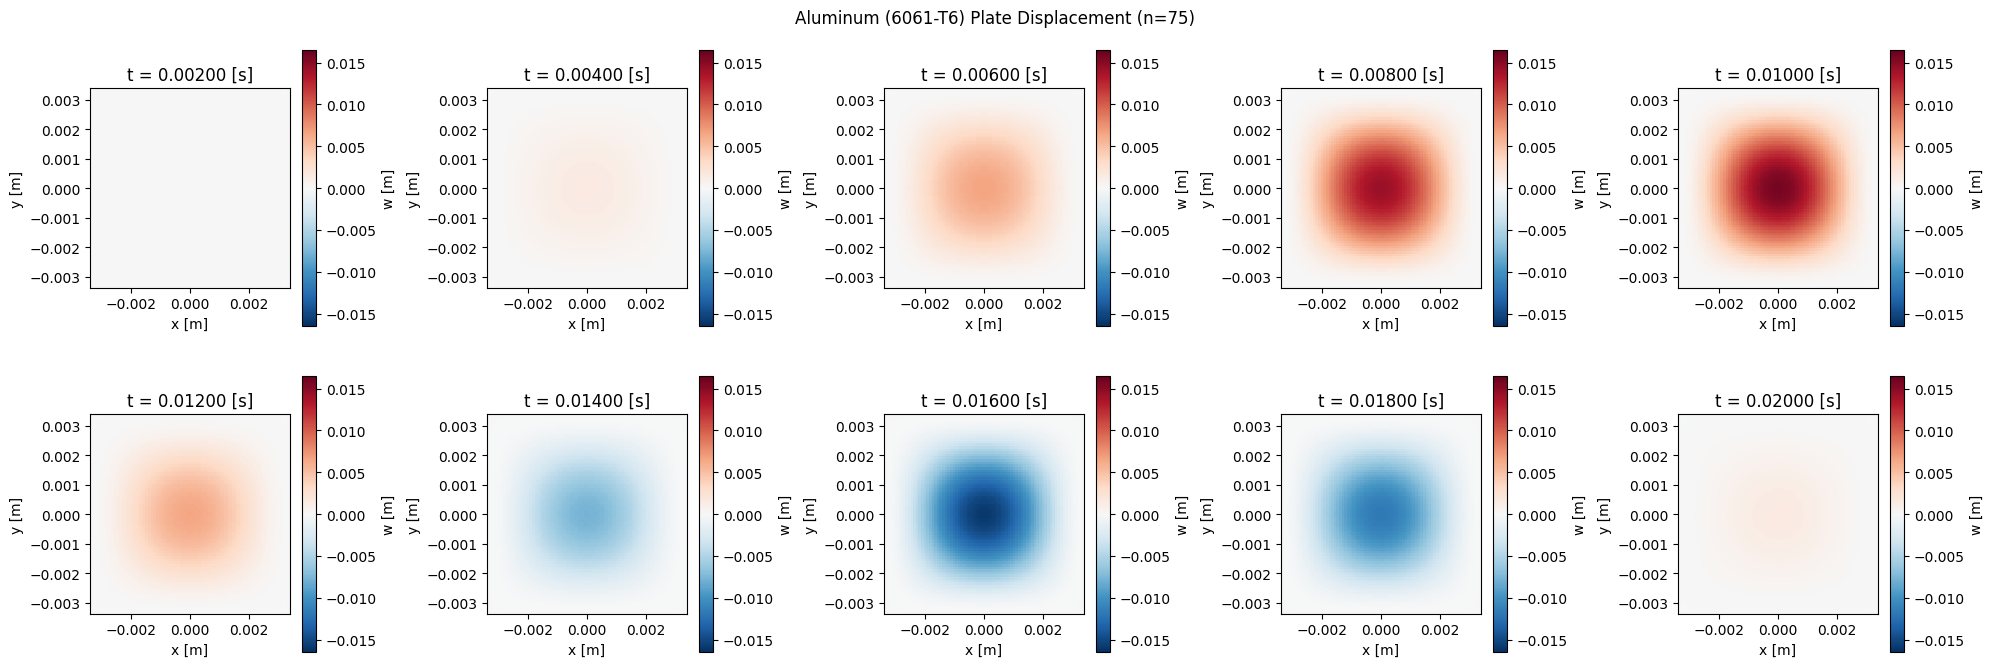

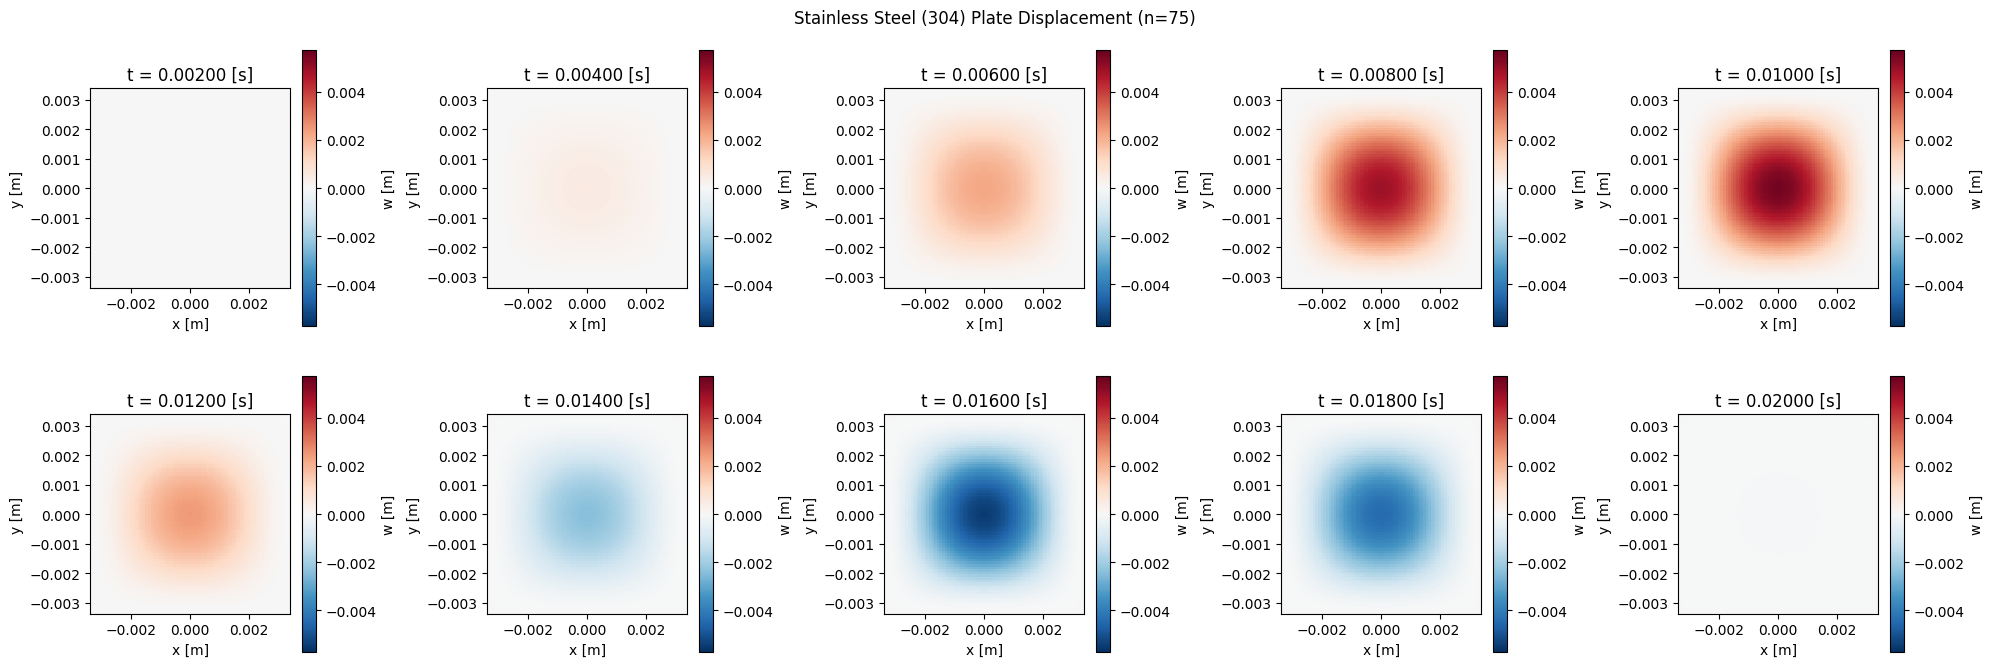

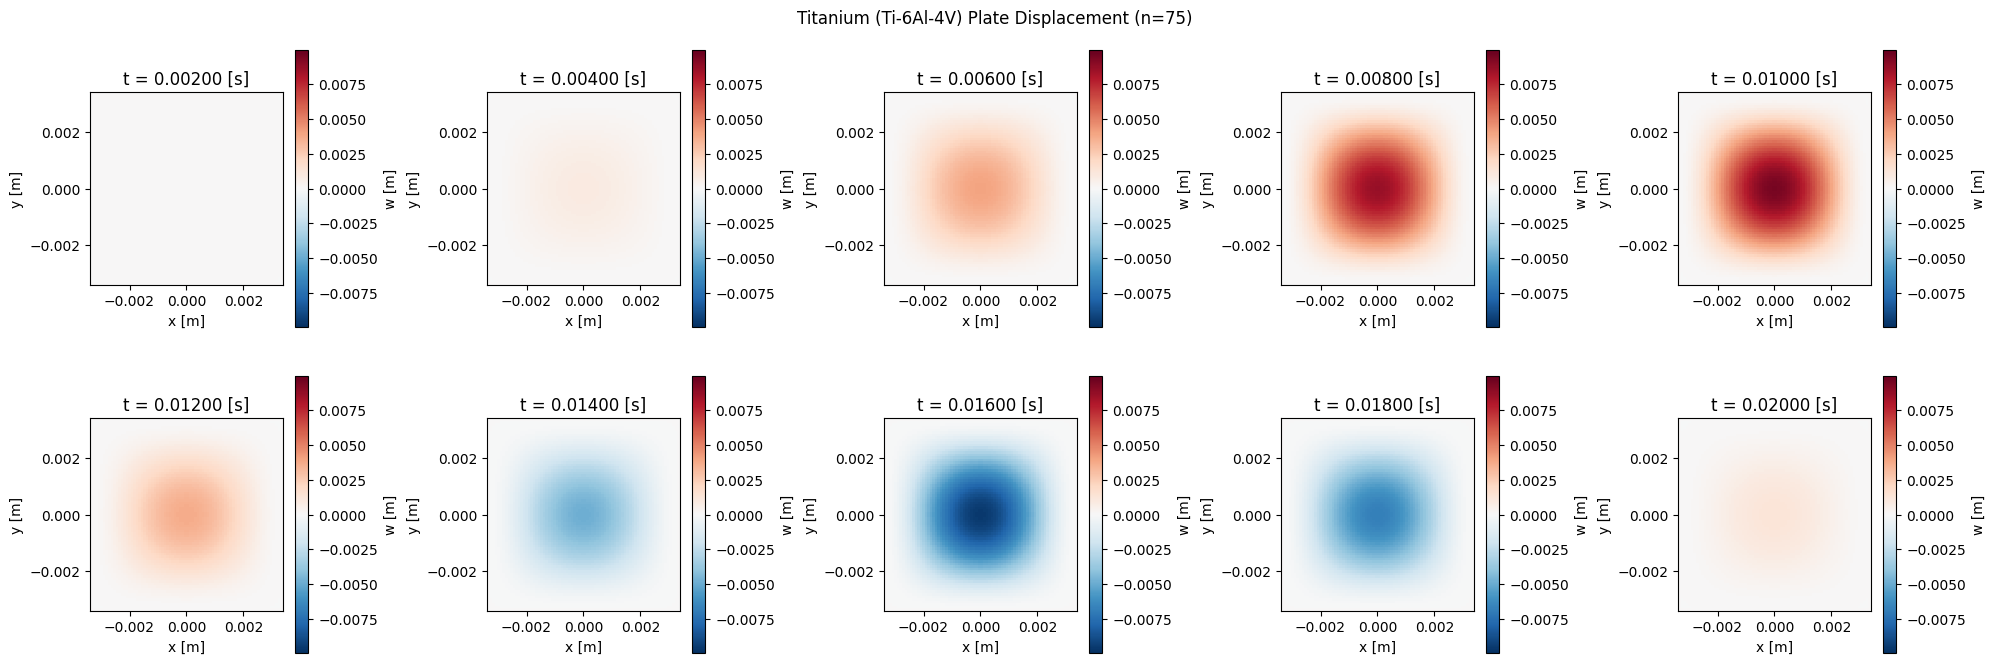

In [9]:
plot_solution(results_AL,"Aluminum (6061-T6)",np.linspace(2000/50,int(2000/5),10,dtype=int))
plot_solution(results_SS_304,"Stainless Steel (304)",np.linspace(2000/50,int(2000/5),10,dtype=int))
plot_solution(results_Ti,"Titanium (Ti-6Al-4V)",np.linspace(2000/50,int(2000/5),10,dtype=int))



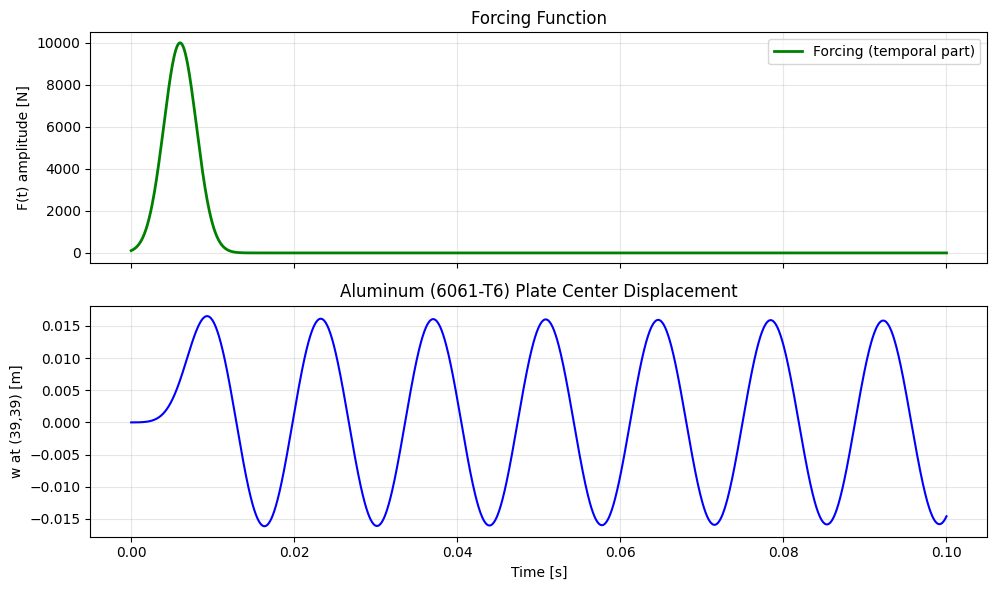

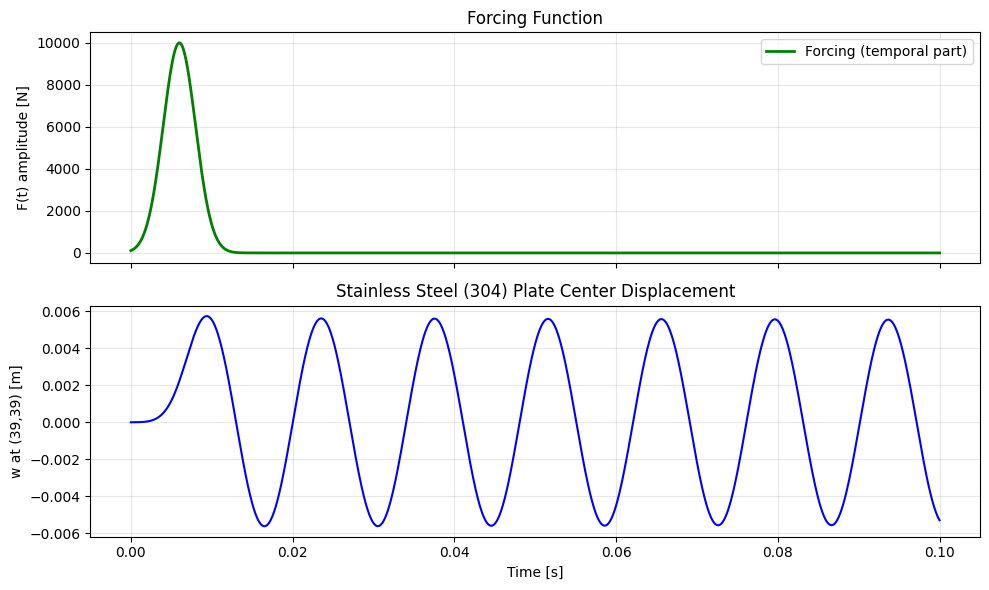

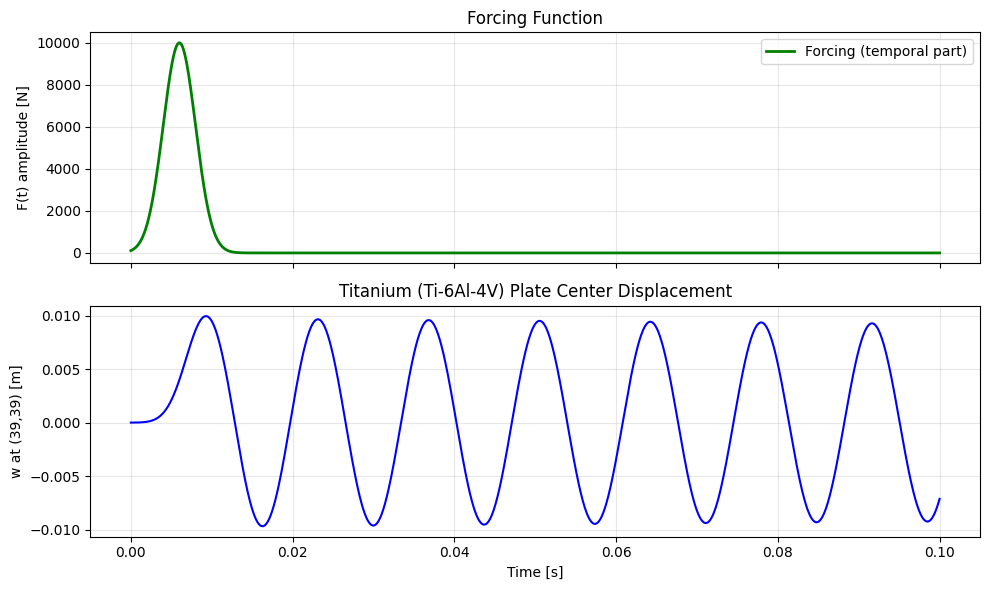

In [10]:
plot_center_displacement(results_AL,"Aluminum (6061-T6)")
plot_center_displacement(results_SS_304,"Stainless Steel (304)")
plot_center_displacement(results_Ti,"Titanium (Ti-6Al-4V)")

In [19]:
from scipy.interpolate import RegularGridInterpolator

def interpolate_solution(w_vec, n_from, n_to, l):
    """Interpolate solution from one grid to another."""
    n_int_from = n_from - 1
    n_int_to = n_to - 1
    
    x_from = np.linspace(-l/2, l/2, n_from + 1)[1:-1]
    x_to = np.linspace(-l/2, l/2, n_to + 1)[1:-1]
    
    w_2d = w_vec.reshape((n_int_from, n_int_from))
    
    # bounds_error=False allows extrapolation, fill_value=None uses nearest value
    interp = RegularGridInterpolator((x_from, x_from), w_2d, 
                                      method='linear', 
                                      bounds_error=False, 
                                      fill_value=None)
    
    X_to, Y_to = np.meshgrid(x_to, x_to, indexing='ij')
    points = np.column_stack([X_to.ravel(), Y_to.ravel()])
    
    return interp(points)


def compute_solutions(n_base: int, n_array: list):
    """
    Compute solutions for base grid and all test grids.
    Run this once and save the results.
    """
    # Physical parameters
    l = 0.5
    rho = 8000
    th = 0.002
    K0 = 2.54E4
    T = 0
    D = 143
    K1 = 5.24
    a = 1e4
    b = 0.002
    c = 0.006
    dt = 0.00005
    t_final = 0.10
    
    params = {
        'l': l, 'dt': dt, 't_final': t_final,
        'rho': rho, 'th': th, 'K0': K0, 'T': T, 'D': D, 'K1': K1,
        'a': a, 'b': b, 'c': c, 'save_every': 1
    }
    
    print(f"Computing base solution (n={n_base})...")
    results_base = solve_newmark_beta(n=n_base, **params)
    w_base = results_base['w'][:, -1]
    
    w_dict = {}
    for n in n_array:
        print(f"Computing solution for n={n}...")
        results = solve_newmark_beta(n=n, **params)
        w_dict[n] = results['w'][:, -1]
    
    print("All solutions computed.")
    
    return {
        'n_base': n_base,
        'w_base': w_base,
        'n_array': n_array,
        'w_dict': w_dict,
        'l': l,
        'params': params
    }


def Spatial_err(solutions: dict):
    """
    Compute and plot spatial errors using precomputed solutions.
    
    Parameters
    ----------
    solutions : dict
        Output from compute_solutions()
    """
    n_base = solutions['n_base']
    w_base = solutions['w_base']
    n_array = solutions['n_array']
    w_dict = solutions['w_dict']
    l = solutions['l']
    
    error_array = []
    dx_array = []
    
    for n in n_array:
        w = w_dict[n]
        
        # Interpolate w onto the base grid
        w_interp = interpolate_solution(w, n, n_base, l)
        
        error = np.linalg.norm(w_interp - w_base) / np.linalg.norm(w_base)
        dx = l / n
        
        error_array.append(error)
        dx_array.append(dx)
    
    dx_array = np.array(dx_array)
    error_array = np.array(error_array)
    
    # Reference function f(dx) = dx^2
    def f_dx_squared(dx):
        scale = error_array[0] / (dx_array[0]**2)
        return scale*dx**2
    
    dx_fine = np.linspace(dx_array.min(), dx_array.max(), 100)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(dx_array, error_array, 'bo-', label='Error', markersize=8)
    ax1.plot(dx_fine, f_dx_squared(dx_fine), 'r--', label=r'$O(\Delta x^2)$')
    ax1.set_xlabel(r'$\Delta x$')
    ax1.set_ylabel('Relative Error')
    ax1.set_title('Error vs Grid Spacing (Linear Scale)')
    ax1.legend()
    ax1.grid(True)
    
    ax2.loglog(dx_array, error_array, 'bo-', label='Error', markersize=8)
    ax2.loglog(dx_fine, f_dx_squared(dx_fine), 'r--', label=r'$O(\Delta x^2)$')
    ax2.set_xlabel(r'$\Delta x$')
    ax2.set_ylabel('Relative Error')
    ax2.set_title('Error vs Grid Spacing (Log Scale)')
    ax2.legend()
    ax2.grid(True, which="both", ls="-", alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return dx_array, error_array

In [12]:
n_base = 80
n_array = [10, 20, 30, 40, 50, 60, 75]
solutions = compute_solutions(n_base, n_array)

Computing base solution (n=80)...
Starting Newmark-beta integration (β=0.25, γ=0.5)...
  Grid: 81x81, Interior points: 6241
  Time step: 5e-05, Final time: 0.1, Total steps: 2000
  Step 201/2000, t = 0.0100
  Step 402/2000, t = 0.0201
  Step 603/2000, t = 0.0302
  Step 804/2000, t = 0.0402
  Step 1005/2000, t = 0.0503
  Step 1206/2000, t = 0.0603
  Step 1407/2000, t = 0.0704
  Step 1608/2000, t = 0.0804
  Step 1809/2000, t = 0.0904
Integration complete. Saved 2001 snapshots.
Computing solution for n=10...
Starting Newmark-beta integration (β=0.25, γ=0.5)...
  Grid: 11x11, Interior points: 81
  Time step: 5e-05, Final time: 0.1, Total steps: 2000
  Step 201/2000, t = 0.0100
  Step 402/2000, t = 0.0201
  Step 603/2000, t = 0.0302
  Step 804/2000, t = 0.0402
  Step 1005/2000, t = 0.0503
  Step 1206/2000, t = 0.0603
  Step 1407/2000, t = 0.0704
  Step 1608/2000, t = 0.0804
  Step 1809/2000, t = 0.0904
Integration complete. Saved 2001 snapshots.
Computing solution for n=20...
Starting Newma

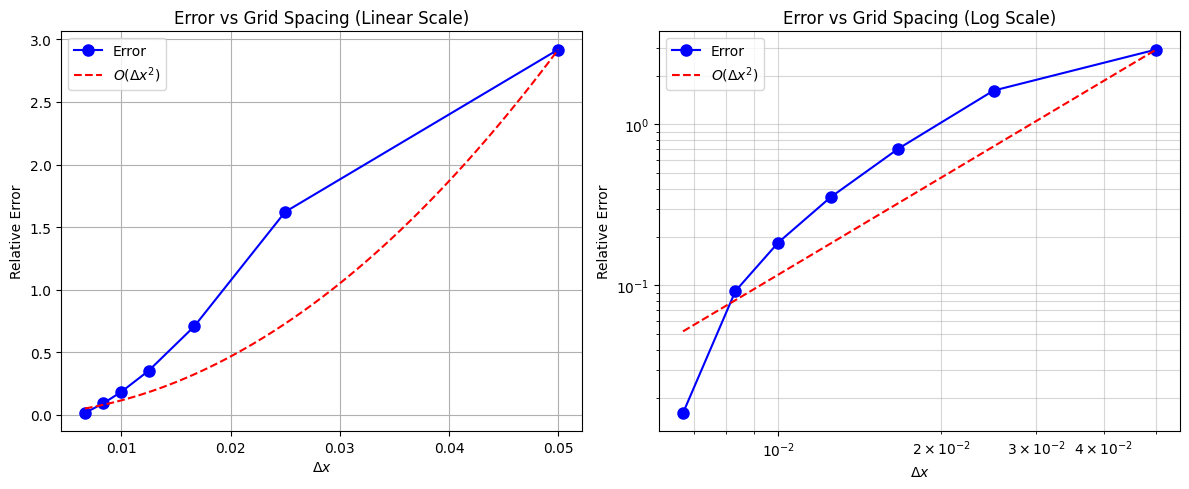

In [20]:
dx_array, error_array = Spatial_err(solutions)

In [14]:
from scipy.interpolate import interp1d

def compute_solutions_temporal(dt_base: float, dt_array: list):
    """
    Compute solutions for base time step and all test time steps.
    Run this once and save the results.
    """
    # Physical parameters
    l = 0.5
    n = 50  
    rho = 8000
    th = 0.002
    K0 = 2.54E4
    T = 0
    D = 143
    K1 = 5.24
    a = 1e4
    b = 0.002
    c = 0.006
    t_final = 0.10
    
    params = {
        'n': n, 'l': l, 't_final': t_final,
        'rho': rho, 'th': th, 'K0': K0, 'T': T, 'D': D, 'K1': K1,
        'a': a, 'b': b, 'c': c, 'save_every': 1
    }
    
    print(f"Computing base solution (dt={dt_base})...")
    results_base = solve_newmark_beta(dt=dt_base, **params)
    t_base = results_base['t']
    w_base = results_base['w']
    
    results_dict = {}
    for dt in dt_array:
        print(f"Computing solution for dt={dt}...")
        results = solve_newmark_beta(dt=dt, **params)
        results_dict[dt] = {
            't': results['t'],
            'w': results['w']
        }
    
    print("All solutions computed.")
    
    return {
        'dt_base': dt_base,
        't_base': t_base,
        'w_base': w_base,
        'dt_array': dt_array,
        'results_dict': results_dict,
        'params': params
    }



def Temporal_err(solutions: dict):
    """
    Compute and plot temporal errors using precomputed solutions.
    
    Parameters
    ----------
    solutions : dict
        Output from compute_solutions_temporal()
    """
    dt_base = solutions['dt_base']
    t_base = solutions['t_base']
    w_base = solutions['w_base']
    dt_array = solutions['dt_array']
    results_dict = solutions['results_dict']
    
    error_array = []
    dt_list = []
    
    for dt in dt_array:
        w_test = results_dict[dt]['w']
        
        # Compare final timestep directly (no interpolation needed)
        error = np.linalg.norm(w_test[:,-1] - w_base[:,-1]) / np.linalg.norm(w_base[:,-1])
        error_array.append(error)
        dt_list.append(dt)
    # Reference function f(dt) = dt^2 (Newmark-beta is 2nd order in time)
    def f_dt_squared(dt):
        scale = error_array[-1] / (dt_array[-1]**2)
        return scale * dt**2
    
    dt_fine = np.linspace(dt_array[0], dt_array[-1], 100)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(dt_array, error_array, 'bo-', label='Error', markersize=8)
    ax1.plot(dt_fine, f_dt_squared(dt_fine), 'r--', label=r'$O(\Delta t^2)$')
    ax1.set_xlabel(r'$\Delta t$')
    ax1.set_ylabel('Relative Error')
    ax1.set_title('Error vs Time Step (Linear Scale)')
    ax1.legend()
    ax1.grid(True)
    
    ax2.loglog(dt_array, error_array, 'bo-', label='Error', markersize=8)
    ax2.loglog(dt_fine, f_dt_squared(dt_fine), 'r--', label=r'$O(\Delta t^2)$')
    ax2.set_xlabel(r'$\Delta t$')
    ax2.set_ylabel('Relative Error')
    ax2.set_title('Error vs Time Step (Log Scale)')
    ax2.legend()
    ax2.grid(True, which="both", ls="-", alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return dt_array, error_array

In [15]:
# Step 1: Compute all solutions once (this takes time)
dt_base = 0.000005  # Very small time step as reference
dt_array = [0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005]
solutions_temporal = compute_solutions_temporal(dt_base, dt_array)

Computing base solution (dt=5e-06)...
Starting Newmark-beta integration (β=0.25, γ=0.5)...
  Grid: 51x51, Interior points: 2401
  Time step: 5e-06, Final time: 0.1, Total steps: 20000
  Step 2001/20000, t = 0.0100
  Step 4002/20000, t = 0.0200
  Step 6003/20000, t = 0.0300
  Step 8004/20000, t = 0.0400
  Step 10005/20000, t = 0.0500
  Step 12006/20000, t = 0.0600
  Step 14007/20000, t = 0.0700
  Step 16008/20000, t = 0.0800
  Step 18009/20000, t = 0.0900
Integration complete. Saved 20001 snapshots.
Computing solution for dt=1e-05...
Starting Newmark-beta integration (β=0.25, γ=0.5)...
  Grid: 51x51, Interior points: 2401
  Time step: 1e-05, Final time: 0.1, Total steps: 10000
  Step 1001/10000, t = 0.0100
  Step 2002/10000, t = 0.0200
  Step 3003/10000, t = 0.0300
  Step 4004/10000, t = 0.0400
  Step 5005/10000, t = 0.0501
  Step 6006/10000, t = 0.0601
  Step 7007/10000, t = 0.0701
  Step 8008/10000, t = 0.0801
  Step 9009/10000, t = 0.0901
Integration complete. Saved 10001 snapshots.


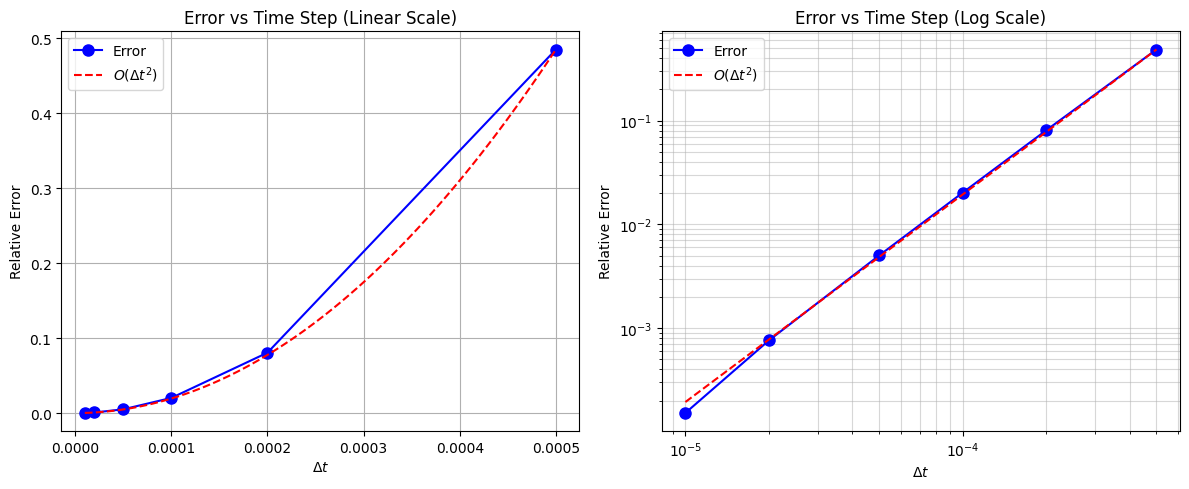

In [16]:
dt_arr, error_arr = Temporal_err(solutions_temporal)

In [17]:
def compute_stresses(results: Dict, E: float, nu: float, time_idx: int = -1) -> Dict:
    """
    Compute the stresses sigma_xx, sigma_yy, and tau_xy at z = +th/2.
    
    Stress formulas:
        sigma_xx = -E/(1-nu^2) * z * (d²w/dx² + nu * d²w/dy²)
        sigma_yy = -E/(1-nu^2) * z * (d²w/dy² + nu * d²w/dx²)
        tau_xy   = -E/(1+nu) * z * d²w/dxdy
    
    Parameters
    ----------
    results : dict
        Results dictionary from solve_newmark_beta
    E : float
        Young's modulus
    nu : float
        Poisson's ratio
    time_idx : int
        Time index to compute stresses at (default: -1 = final time)
    
    Returns
    -------
    stresses : dict
        Dictionary containing sigma_xx, sigma_yy, tau_xy as 2D arrays
    """
    params = results['params']
    info = results['info']
    n = params['n']
    l = params['l']
    th = params['th']
    h = l / n  # Grid spacing
    
    # Get displacement at specified time
    w_vec = results['w'][:, time_idx]
    
    # Convert to 2D grid
    w_grid = vector_to_grid(w_vec, info)
    
    # z = +th/2 (top surface)
    z = th / 2
    
    # Compute second derivatives using finite differences
    # Interior points only (where we have data)
    n_pts = n + 1
    
    # d²w/dx² using central difference
    d2w_dx2 = np.zeros((n_pts, n_pts))
    for i in range(1, n_pts - 1):
        for j in range(n_pts):
            d2w_dx2[i, j] = (w_grid[i+1, j] - 2*w_grid[i, j] + w_grid[i-1, j]) / h**2
    
    # d²w/dy² using central difference
    d2w_dy2 = np.zeros((n_pts, n_pts))
    for i in range(n_pts):
        for j in range(1, n_pts - 1):
            d2w_dy2[i, j] = (w_grid[i, j+1] - 2*w_grid[i, j] + w_grid[i, j-1]) / h**2
    
    # d²w/dxdy using central difference
    d2w_dxdy = np.zeros((n_pts, n_pts))
    for i in range(1, n_pts - 1):
        for j in range(1, n_pts - 1):
            d2w_dxdy[i, j] = (w_grid[i+1, j+1] - w_grid[i+1, j-1] 
                            - w_grid[i-1, j+1] + w_grid[i-1, j-1]) / (4 * h**2)
    
    # Compute stresses
    sigma_xx = -E / (1 - nu**2) * z * (d2w_dx2 + nu * d2w_dy2)
    sigma_yy = -E / (1 - nu**2) * z * (d2w_dy2 + nu * d2w_dx2)
    tau_xy = -E / (1 + nu) * z * d2w_dxdy
    
    return {
        'sigma_xx': sigma_xx,
        'sigma_yy': sigma_yy,
        'tau_xy': tau_xy,
        'd2w_dx2': d2w_dx2,
        'd2w_dy2': d2w_dy2,
        'd2w_dxdy': d2w_dxdy,
        'w_grid': w_grid,
        'z': z,
        'time': results['t'][time_idx]
    }


def plot_stresses(results: Dict, E: float, nu: float, time_idx: int = -1):
    """
    Plot the stresses sigma_xx, sigma_yy, and tau_xy at z = +th/2.
    
    Parameters
    ----------
    results : dict
        Results dictionary from solve_newmark_beta
    E : float
        Young's modulus
    nu : float
        Poisson's ratio
    time_idx : int
        Time index to plot stresses at (default: -1 = final time)
    save_path : str, optional
        Path to save the figure
    """
    # Compute stresses
    stresses = compute_stresses(results, E, nu, time_idx)
    
    params = results['params']
    info = results['info']
    n = params['n']
    l = params['l']
    h = l / n
    
    # Create coordinate arrays (centered at origin)
    x, y = get_grid_coordinates(info, h)
    X, Y = np.meshgrid(x, y)
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Plot sigma_xx
    im0 = axes[0].pcolormesh(X, Y, stresses['sigma_xx'].T, shading='auto', cmap='RdBu_r')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].set_title(r'$\sigma_{xx}$ [Pa]')
    axes[0].set_aspect('equal')
    plt.colorbar(im0, ax=axes[0])
    
    # Plot sigma_yy
    im1 = axes[1].pcolormesh(X, Y, stresses['sigma_yy'].T, shading='auto', cmap='RdBu_r')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].set_title(r'$\sigma_{yy}$ [Pa]')
    axes[1].set_aspect('equal')
    plt.colorbar(im1, ax=axes[1])
    
    # Plot tau_xy
    im2 = axes[2].pcolormesh(X, Y, stresses['tau_xy'].T, shading='auto', cmap='RdBu_r')
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('y')
    axes[2].set_title(r'$\tau_{xy}$ [Pa]')
    axes[2].set_aspect('equal')
    plt.colorbar(im2, ax=axes[2])
    
    plt.suptitle(f'Stresses at z = +th/2, t = {stresses["time"]:.6f} s', fontsize=12)
    plt.tight_layout()

    
    plt.show()
    
    return stresses


def plot_stresses_evolution(results: Dict, E: float, nu: float, material: str,
                            time_indices: Optional[list] = None, n_cols: int = 5):
    """
    Plot the evolution of stresses at multiple time steps.
    Each stress component gets 2 rows of 5 subplots (10 time steps total).
    
    Parameters
    ----------
    results : dict
        Results dictionary from solve_newmark_beta
    E : float
        Young's modulus
    nu : float
        Poisson's ratio
    material : str
        Material name for title
    time_indices : list, optional
        Indices of time steps to plot (default: 10 equally spaced)
    n_cols : int
        Number of columns per row (default: 5)
    """
    t = results['t']
    params = results['params']
    info = results['info']
    n = params['n']
    l = params['l']
    h = l / n
    
    if time_indices is None:
        time_indices = np.linspace(0, len(t)-1, 10, dtype=int)
    
    n_times = len(time_indices)
    n_rows_per_component = int(np.ceil(n_times / n_cols))
    
    # Create coordinate arrays
    x, y = get_grid_coordinates(info, h)
    X, Y = np.meshgrid(x, y)
    
    # Compute all stresses first to get global color limits
    all_stresses = [compute_stresses(results, E, nu, idx) for idx in time_indices]
    
    vmax_xx = max(np.abs(s['sigma_xx']).max() for s in all_stresses)
    vmax_yy = max(np.abs(s['sigma_yy']).max() for s in all_stresses)
    vmax_xy = max(np.abs(s['tau_xy']).max() for s in all_stresses)
    
    # --- Plot sigma_xx ---
    fig1, axes1 = plt.subplots(n_rows_per_component, n_cols, 
                                figsize=(4*n_cols, 3.5*n_rows_per_component))
    axes1_flat = axes1.flatten()
    
    for i, (idx, stresses) in enumerate(zip(time_indices, all_stresses)):
        im = axes1_flat[i].pcolormesh(X, Y, stresses['sigma_xx'].T, shading='auto',
                                       cmap='RdBu_r', vmin=-vmax_xx, vmax=vmax_xx)
        axes1_flat[i].set_title(f't = {t[idx]:.5f} s')
        axes1_flat[i].set_aspect('equal')
        plt.colorbar(im, ax=axes1_flat[i])
    
    # Hide unused subplots
    for i in range(n_times, len(axes1_flat)):
        axes1_flat[i].axis('off')
    
    fig1.suptitle(rf'$\sigma_{{xx}}$ Evolution for {material} Plate at z = +t/2', fontsize=20)
    fig1.tight_layout()
    
    # --- Plot sigma_yy ---
    fig2, axes2 = plt.subplots(n_rows_per_component, n_cols,
                                figsize=(4*n_cols, 3.5*n_rows_per_component))
    axes2_flat = axes2.flatten()
    
    for i, (idx, stresses) in enumerate(zip(time_indices, all_stresses)):
        im = axes2_flat[i].pcolormesh(X, Y, stresses['sigma_yy'].T, shading='auto',
                                       cmap='RdBu_r', vmin=-vmax_yy, vmax=vmax_yy)
        axes2_flat[i].set_title(f't = {t[idx]:.5f} s')
        axes2_flat[i].set_aspect('equal')
        plt.colorbar(im, ax=axes2_flat[i])
    
    # Hide unused subplots
    for i in range(n_times, len(axes2_flat)):
        axes2_flat[i].axis('off')
    
    fig2.suptitle(rf'$\sigma_{{yy}}$ Evolution for {material} Plate at z = +t/2', fontsize=20)
    fig2.tight_layout()
    
    # --- Plot tau_xy ---
    fig3, axes3 = plt.subplots(n_rows_per_component, n_cols,
                                figsize=(4*n_cols, 3.5*n_rows_per_component))
    axes3_flat = axes3.flatten()
    
    for i, (idx, stresses) in enumerate(zip(time_indices, all_stresses)):
        im = axes3_flat[i].pcolormesh(X, Y, stresses['tau_xy'].T, shading='auto',
                                       cmap='RdBu_r', vmin=-vmax_xy, vmax=vmax_xy)
        axes3_flat[i].set_title(f't = {t[idx]:.5f} s')
        axes3_flat[i].set_aspect('equal')
        plt.colorbar(im, ax=axes3_flat[i])
    
    # Hide unused subplots
    for i in range(n_times, len(axes3_flat)):
        axes3_flat[i].axis('off')
    
    fig3.suptitle(rf'$\tau_{{xy}}$ Evolution for {material} Plate at z = +t/2', fontsize=20)
    fig3.tight_layout()
    
    plt.show()
    
    return fig1, fig2, fig3

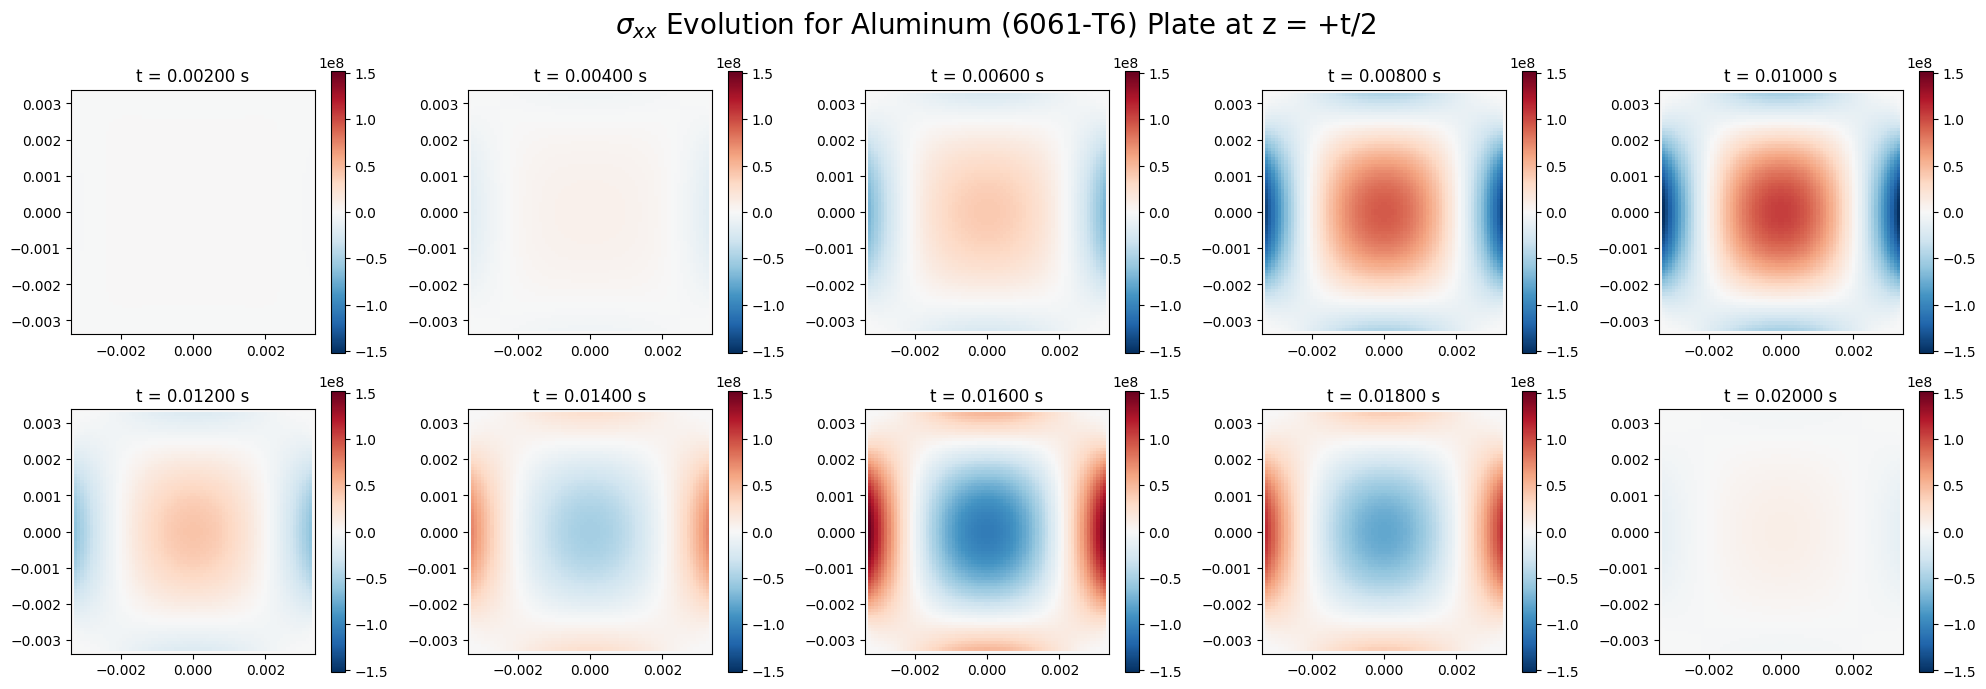

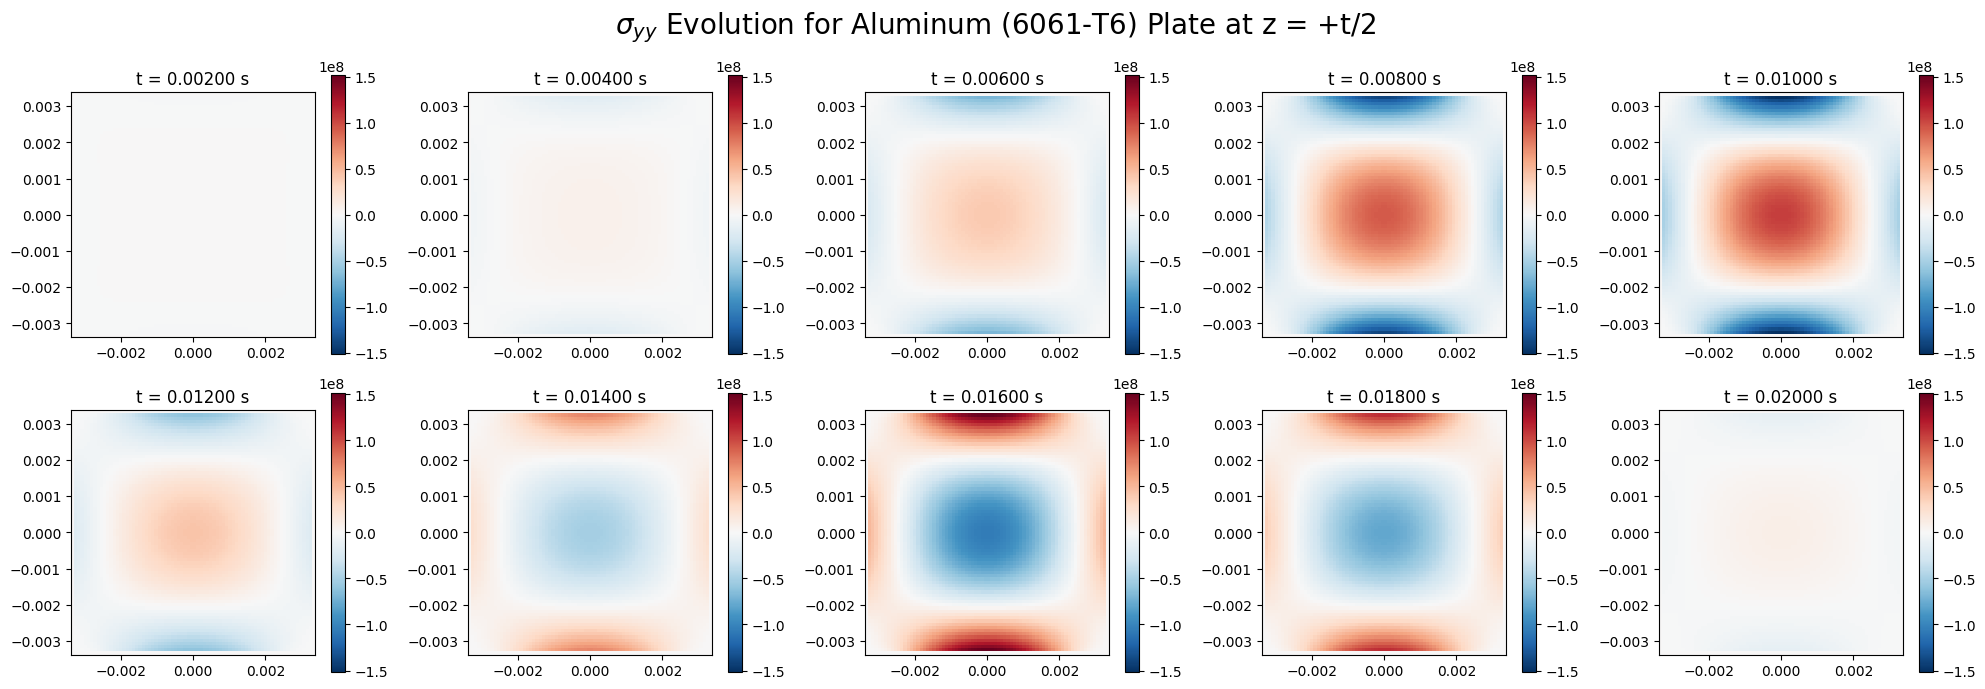

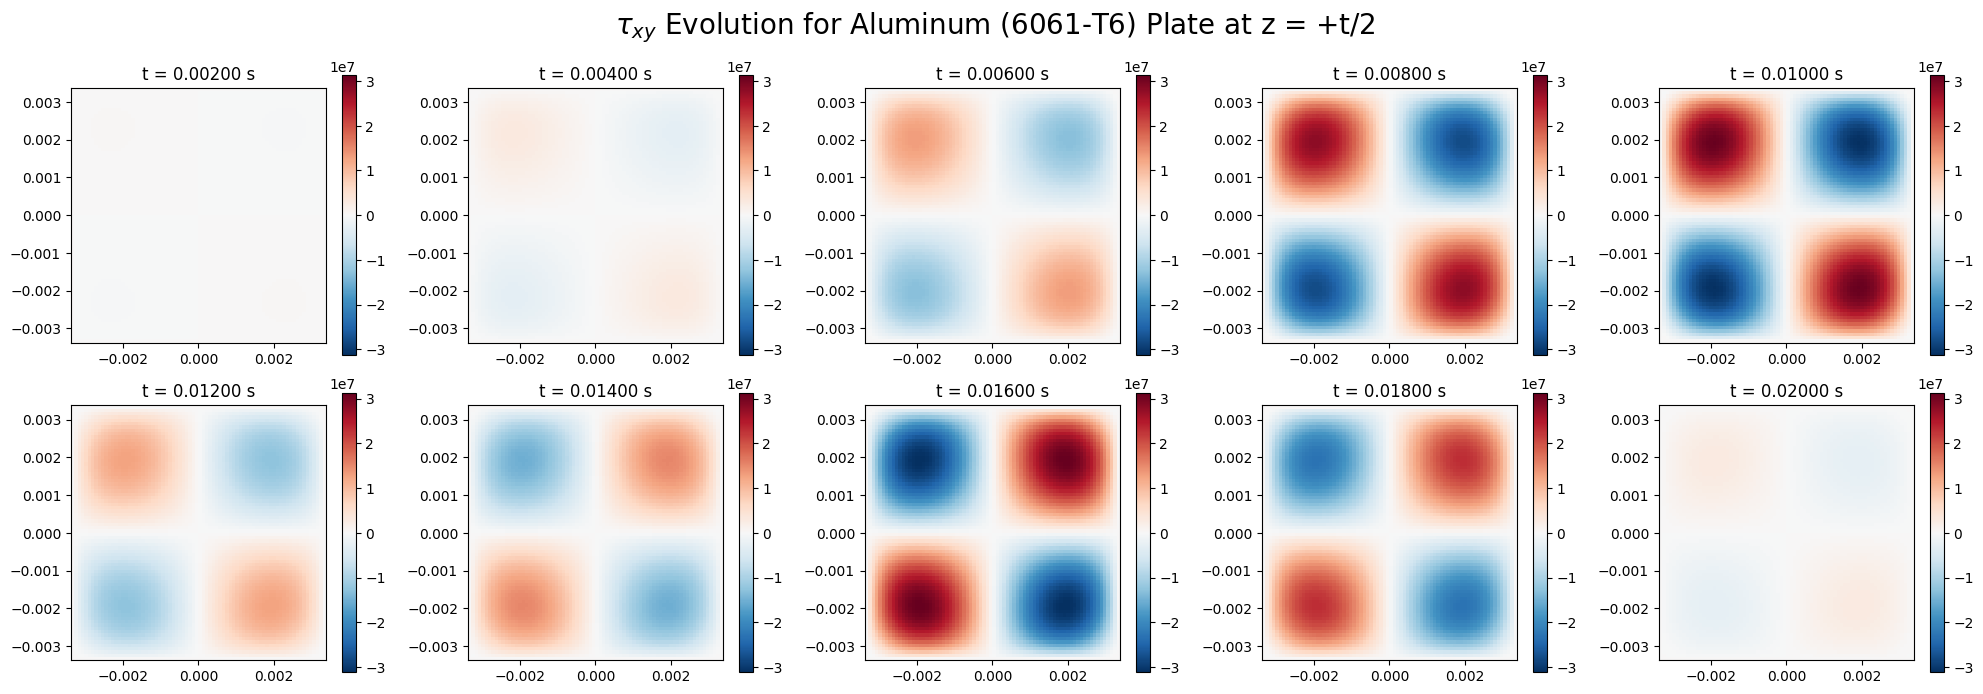

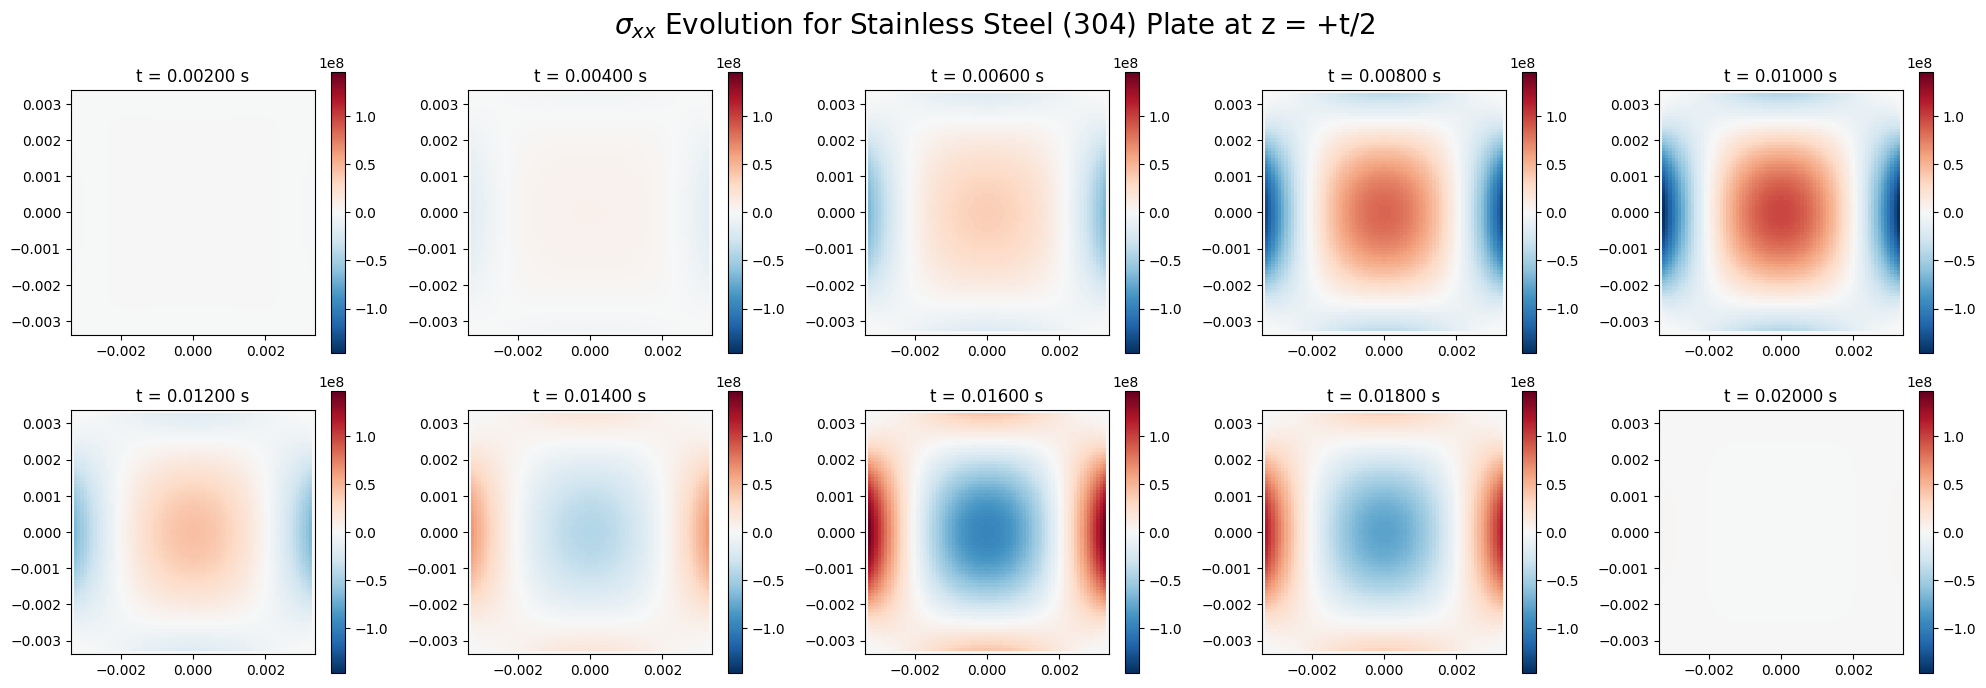

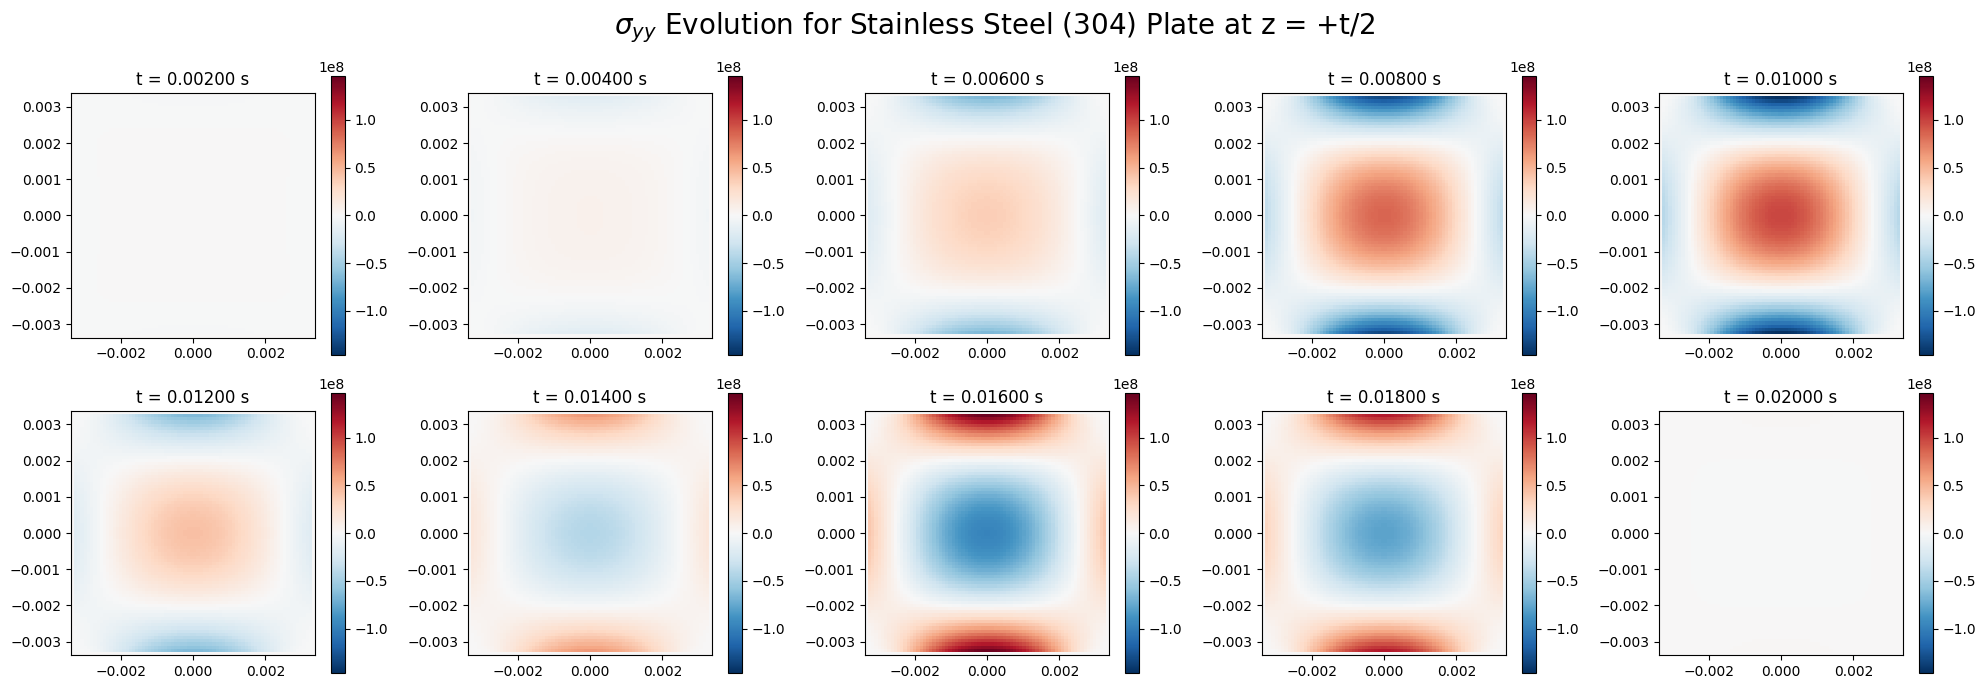

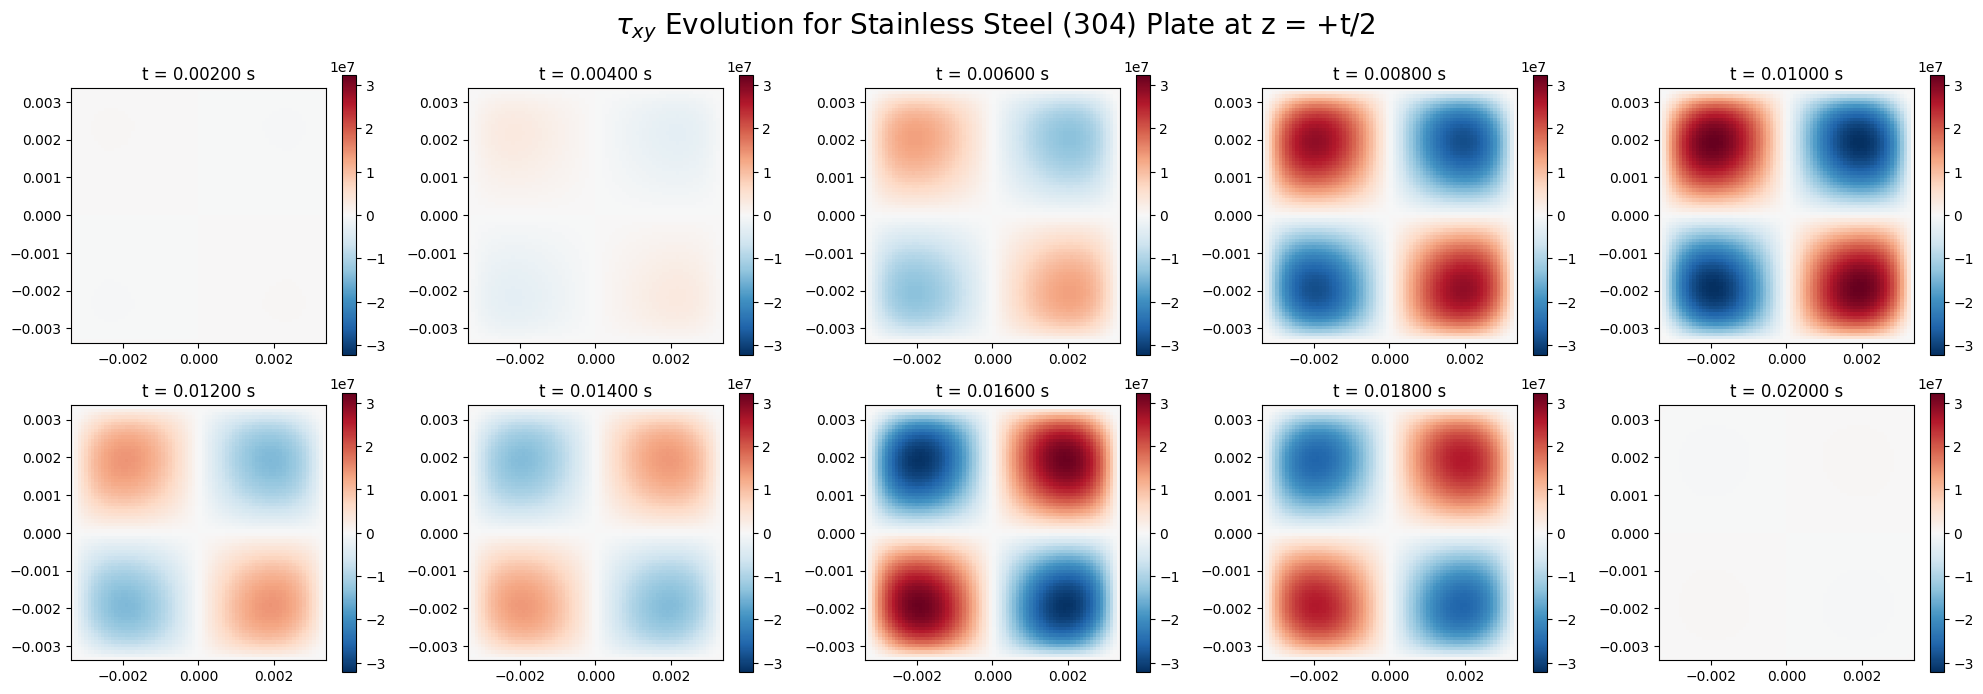

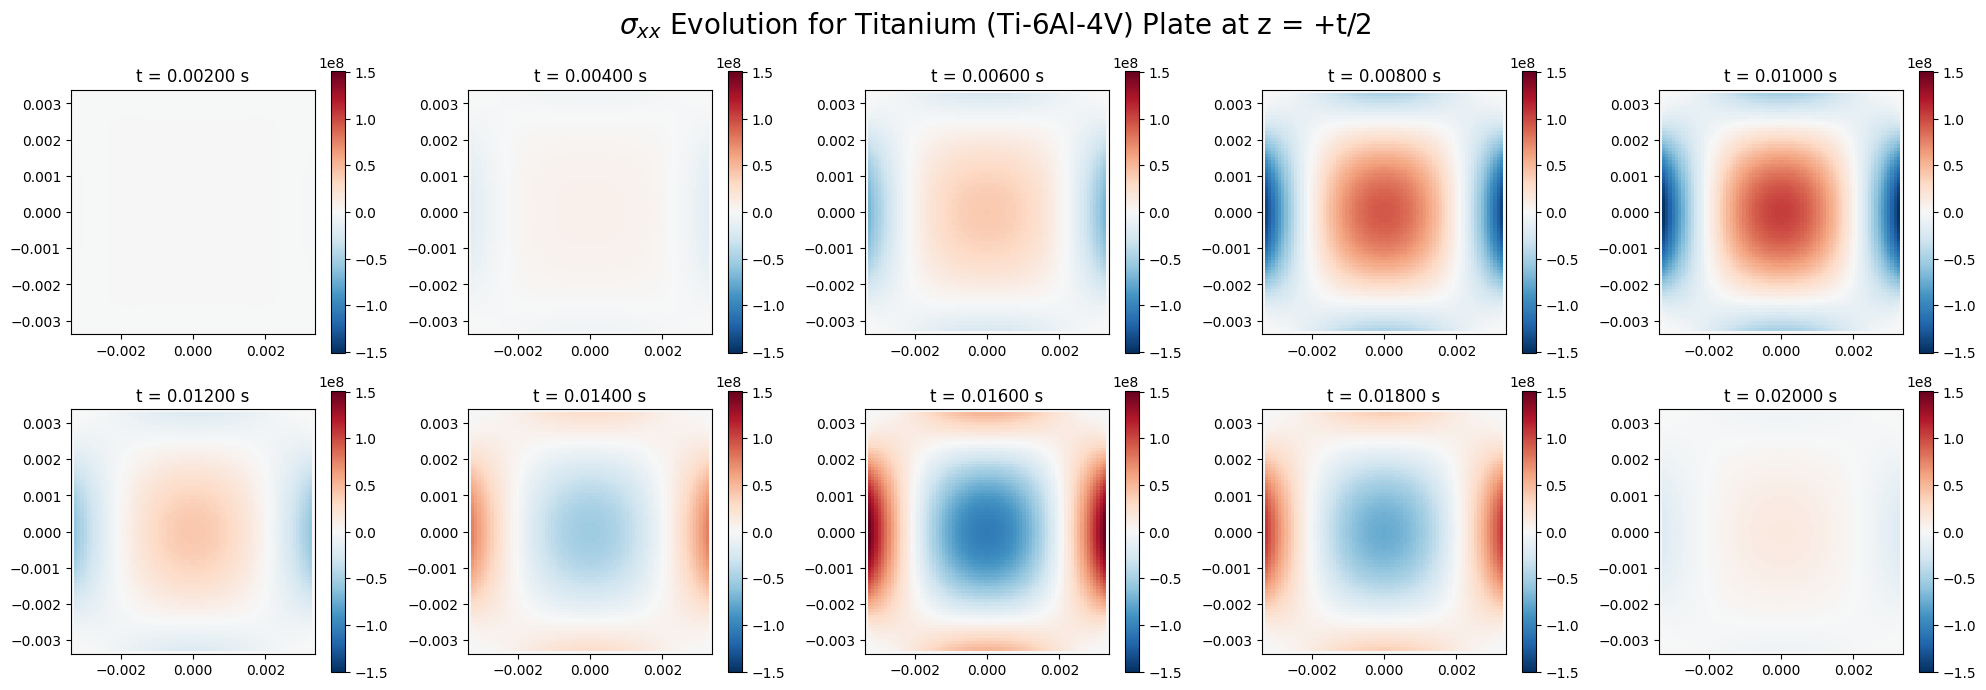

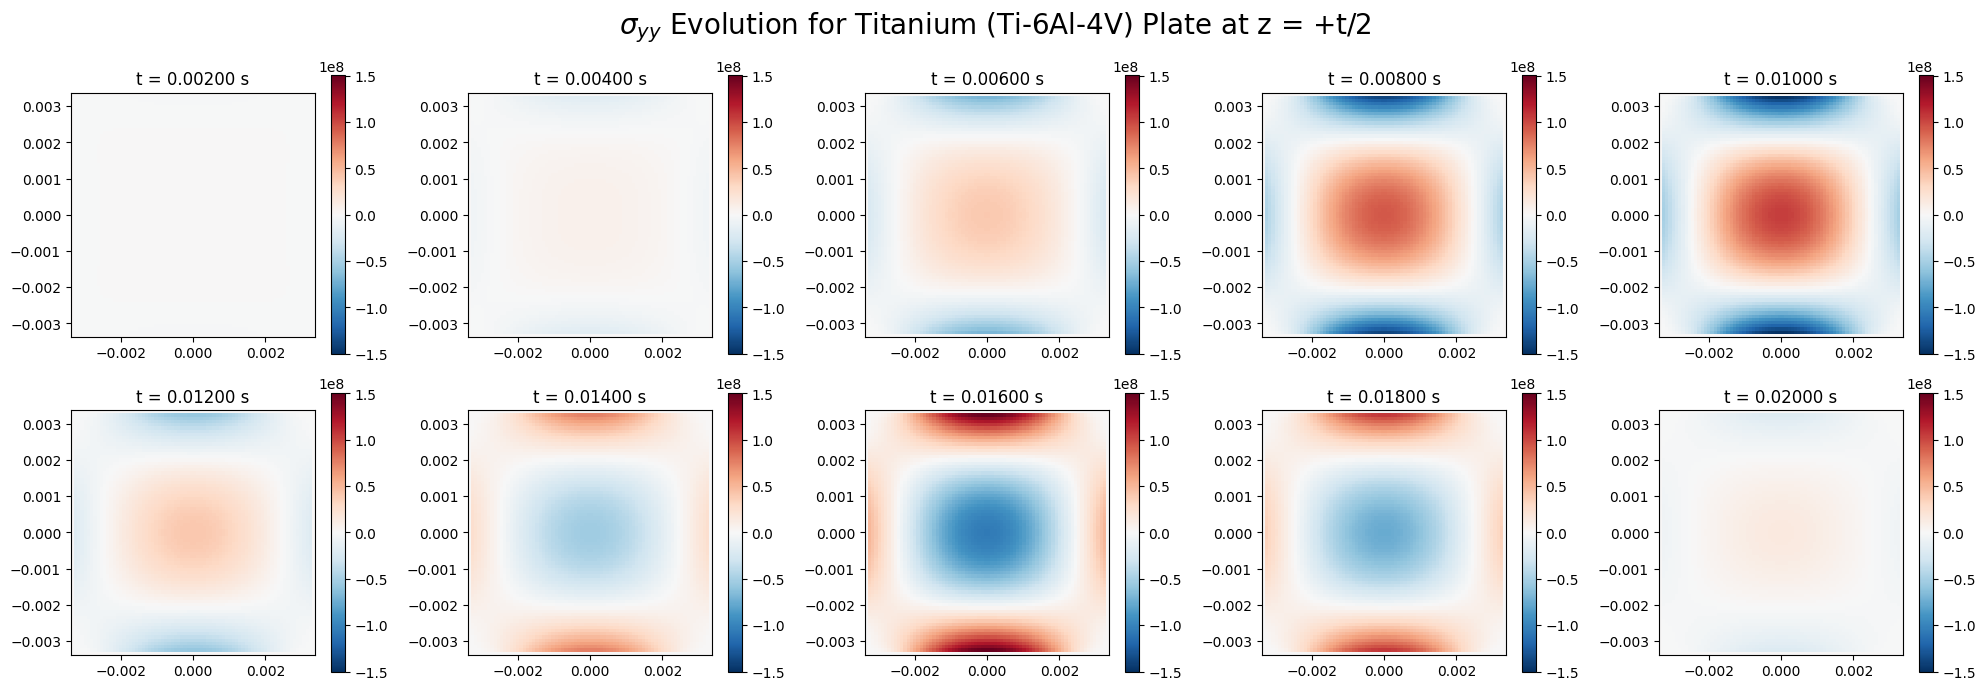

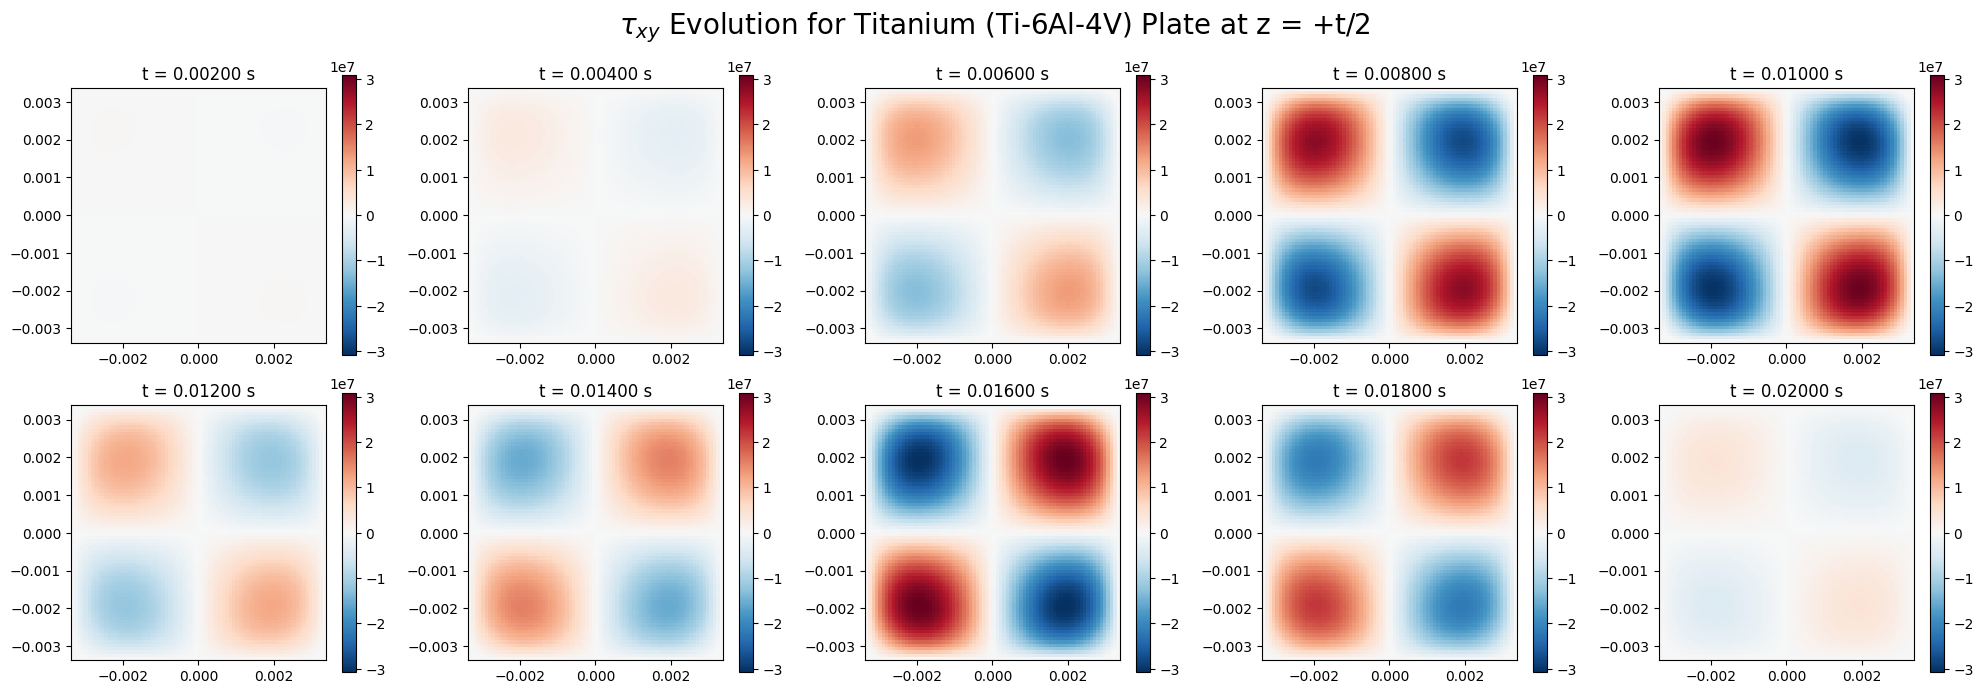

(<Figure size 2000x700 with 20 Axes>,
 <Figure size 2000x700 with 20 Axes>,
 <Figure size 2000x700 with 20 Axes>)

In [18]:
plot_stresses_evolution(results_AL,70E9,0.33, "Aluminum (6061-T6)",np.linspace(2000/50,int(2000/5),10,dtype=int))
plot_stresses_evolution(results_SS_304,200E9,0.28, "Stainless Steel (304)",np.linspace(2000/50,int(2000/5),10,dtype=int))
plot_stresses_evolution(results_Ti,115E9,0.334, "Titanium (Ti-6Al-4V)",np.linspace(2000/50,int(2000/5),10,dtype=int))